In [108]:
import pandas as pd
import numpy as np
import re
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split as sk_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
%matplotlib inline

# Milestone 3: Traditional statistical and machine learning methods, due Wednesday, April 19, 2017

Think about how you would address the genre prediction problem with traditional statistical or machine learning methods. This includes everything you learned about modeling in this course before the deep learning part. Implement your ideas and compare different classifiers. Report your results and discuss what challenges you faced and how you overcame them. What works and what does not? If there are parts that do not work as expected, make sure to discuss briefly what you think is the cause and how you would address this if you would have more time and resources. 

You do not necessarily need to use the movie posters for this step, but even without a background in computer vision, there are very simple features you can extract from the posters to help guide a traditional machine learning model. Think about the PCA lecture for example, or how to use clustering to extract color information. In addition to considering the movie posters it would be worthwhile to have a look at the metadata that IMDb provides. 

You could use Spark and the [ML library](https://spark.apache.org/docs/latest/ml-features.html#word2vec) to build your model features from the data. This may be especially beneficial if you use additional data, e.g., in text form.

You also need to think about how you are going to evaluate your classifier. Which metrics or scores will you report to show how good the performance is?

The notebook to submit this week should at least include:

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances you achieved, and how you might be able to improve them in the future

## Questions to answer: 

### Our Approach: Two Main Models: 
For our approach, we use two main models a random forest and a LASSO.  IN particular, we decided to focus on 10 main predictos about the movies (from who directed, the rating, and popularity) to an analysis of the textual response in the overview. However, before we could use our textual data for prediction we changed our textual response to become a count vectorizer.

### Going from text to TFIDF
For all of our models, we changed our overview to become a count vectorizer. A count vectorizer takes all of the words that from all of the different overviews and then makes a column for each unique word. Then we create a matrix called a document word matrix. This matrix holds the number of times each unique word is discovered in the document. We also got rid of any stop words that are common in the english language (e.g. "the" "but" "and" because we believed that these would not provide much information but would dominate our results.) 

- **What are we predicting exactly?**

So, we are trying to predict movie genres. However, we have that each movie has multiple genres. This leads to the question of how we can predict multiple classifiers for the same object. This more general question is called a multilabel clasification problem. We will explore some of our specifications for this problem below. 

One of the best and most standard solution to do multilable classification is called "one vs. rest" classifiers. These classifiers create n models for each of the n labels. One of the advantages of this model is its interpretability and, for our cases, its ease. We can easily create a pipeline that then does these predictions for us. For an implementation of one vs. all, look at scikit learn: http://scikit-learn.org/dev/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

We will likely be using this in our early attempts at classification. 

- **What does it means to be succesful? What is our metric for success?**

*adapted from http://people.oregonstate.edu/~sorowerm/pdf/Qual-Multilabel-Shahed-CompleteVersion.pdf*

Here are a few options for our measure of accuracy:

#### Exact Match Ratio
The exact match ratio only considers a correct answer for our multilabel data if it is exactly correct (e.g. if there are three classes, we only classify this as correct if we correctly identify all three classes.) 

#### Accuracy 
Accuracy is a simple way of "goodness of prediction." It is defined as follows 

$$ \frac{1}{n} \sum_i^{n}  \frac{|Y_i\cap Z_i|}{|Y_i \cup Z_i|}$$

Where $$Y_i\cap Z_i $$ refers to the total number of correctly predicted labels over the total number of labels for that instance. So, if for example we predicted [romance, action]  and the true labels were [romance, comedy, horror], this would receive an accuracy of 1/4 because there was one correct prediction and 4 unique labels. 


#### Hamming Loss 
The final and most common form of error for multilable predictions is hamming loss. Hamming loss takes into account both the prediction error (an incorrect error is predicted) and the missing error (a relevant lable is NOT predicted.) this is defined as follows below 

$$ \text{HammingLoss, HL} = \frac{1}{kn} \sum_{i}^{n} \sum_l^k [l \in  Z_i \wedge l \notin Y_i)  + I(l \notin Z_i \wedge  l \in Y_i)]$$

*For this project, we will use the hamming loss, which is defined above.* There is a convenient function in `sklearn` to calculate hamming loss: `sklearn.metrics.hamming_loss`

- What is our first modeling approach? Why? 
Our first modeling approach was to use a random forest classifier use one vs all classifier. One VS all classifier essentially make a binary prediction for every one of the different genres. It predicts whether or not we should classify this movie within this genre or not. This allows us to make predictions for each of the individual genres. HOwever, it does suffer from the assumption that each of these genres are independent (we're essentially throwing away information with this assumption.) 
- What is our second modeling approach? Why? 
The second approach we used was a LASSO model. We chose a LASSO model becaue we knew that with our bag of words model we would have a significant number of predictors ~10,000. Unfortunatley, this could lead us to compltely overfitting in our model. One way of avoiding this is to use a model that regularizes. The LASSO, in particular, does a good job of this because it shrinks down our predictors to zero. We ultimately found, however, that this LASSO model did not do as well as our random forest 


- Our extension
Beyond the basic unigram model, we also compared our model with other bag of n words. In this case, we find that our unigram model does slightly better than a bigram, trigram, or 4-gram model. 

In [4]:
'''
An example of hamming loss. We have true labels:

[0, 1]
[1, 1]

And predicted labels:

[0, 0]
[0, 0]

Hamming loss is .75
'''
hamming_loss(np.array([[0, 1], [1, 1]]), np.zeros((2, 2)))

0.75

### Data Collection & Cleaning

## Decision for dropping
Here we choose to drop the missing data instead of imputing because it is non numerical and avereraging or finding means does not make sense in this scencario

In [204]:
# read in the data
train = pd.read_csv("train_full.csv")
train = train.rename(columns={'lead actors': 'actors'})

# drop a rogue column
train.drop("Unnamed: 0", axis = 1, inplace = True)

# drop the handful of columns containing na
train = train.dropna(axis=0).copy()

print "Dataframe shape:", train.shape
train.head(1)

Dataframe shape: (7143, 32)


,10402,10749,10751,10752,10769,10770,12,14,16,18,...,actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,1,...,"[u'Amy Adams', u'Jeremy Renner', u'Forest Whit...",329865,Taking place after alien crafts land around th...,25.66195,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,Arrival,False,6.9,3510


## Converting Summaries Into Text Feature Documents Counts 

In [210]:
y = features[features.columns[:20]]

In [23]:
# Let's add some text features!
string_matrix = train[["overview"]].values

### We need to get rid of the list within a list format, 
## Convert to simply be a list of strings 
string_matrix= [string_matrix[i][0] for i in range(0,len(string_matrix))]

In [25]:
#### This TFIDF allows us to get rid of stop words from the english language that would otherwise dominate 
## our analysis 
def get_TFIDF(n_grams=1):
    '''
    Returns a TFIDF matrix for the essay_df matrix given a certain number of n_grams.
    '''
    vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, n_grams))
    corpus = string_matrix
    return vectorizer.fit_transform(corpus)

In [26]:
X = get_TFIDF()

## Using Random Forest on TFIDF Summary Data To Predict Genre
For our models, we decided to only use the summary data to make predictions. We did this, in part, because it gave us a ready comparison to our other models using movie posters. Can we make more accurate predictions using the summary data or the movie poster data? 

In our random forest, we tune the number of features per a split. This essentially allows us to find out at every point in the tree, how many of the different predictors we randomly consider at each point. 

In [73]:
features_list = [2,4, 6, 8,10,40,100,500]

hamming_loss_list = [] 
accuracy_list = [] 
for num_features in features_list: 
    print num_features 
    temp_hamming_loss = [] 
    temp_accuracy = [] 
    for train_ind, test_ind in KFold(n_splits = NUM_FOLDS).split(X):
        indices = train_ind
        X_train, X_test = X[train_ind], X[test_ind]
        y_train = y.iloc[train_ind]
        y_test = y.iloc[test_ind]
    
    
        text_classifier = OneVsRestClassifier(RandomForestClassifier(max_features = num_features))
    
        y_hat = text_classifier.fit(X_train, y_train).predict(X_test)

        temp_hamming_loss.append(hamming_loss(y_hat, y_test))
        ### make into numpy array for below function 
        y_test = np.array(y_test)
        ### Our accuracy_score function does not work on matrices, this allows us to 
        ## Take these predictions by row 
        accuracy = [accuracy_score(y_hat[i], y_test[i]) for i in range(0, len(y_test))]
        temp_accuracy.append(np.mean(accuracy))
    hamming_loss_list.append(np.mean(temp_hamming_loss))
    accuracy_list.append(np.mean(temp_accuracy))

2
4
8
10
40
100
500
1000
2000


In [74]:
accuracy_list

[0.92855242895142087,
 0.92899342013159736,
 0.92888142237155258,
 0.92897242055158902,
 0.92969340613187734,
 0.92926641467170656,
 0.92463250734985303,
 0.92472350552988936,
 0.92379252414951696]

4


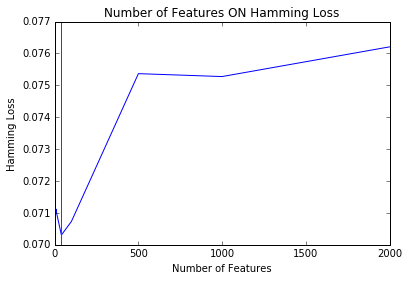

In [88]:
print np.argmax(accuracy_list)

plt.plot(features_list, hamming_loss_list)
best_index = np.argmin(hamming_loss_list)
plt.axvline(features_list[best_index], c='r', label= str(best_index))
plt.ylabel("Hamming Loss")
plt.xlabel("Number of Features")
plt.title("Random Forest: Number of Features on Hamming Loss")

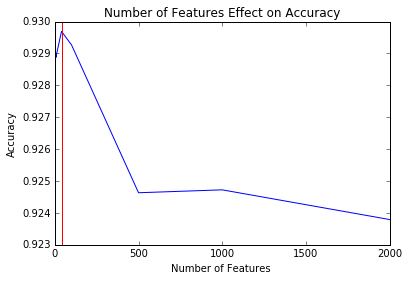

In [89]:
plt.plot(features_list, accuracy_list)
best_index = np.argmax(accuracy_list)
plt.axvline(features_list[best_index], c='r', label= str(best_index))
plt.ylabel("Accuracy")
plt.xlabel("Number of Features ")
plt.title("Random Forest: Number of Features Effect on Accuracy")

## Agreement between accuracy and Hamming Loss
It appears that both our accuracy and hamming loss seem to be in agreement. They are giving us very good predictions ~93%. As we will see later on, these predictions are even better than the predictions we receive using neural networks and poster data. Perhaps there is more information coded into the summary's than there are in the movie posters! 

# Model 2: LASSO 
For our second model, we will be using a LASSO. We chose to use a LASSO because it naturally does dimensionality reduction. With our bag of words model, we have the number of predictions in the 10s of thousands. As a result, we need a method that can do some regularization or dimensionality reduction. 

To tune the lasso, we tune the alpha value. The alpha value controls how much regularization we apply to our model. The more regularization the more predictors that the LASSO will bring to zero. 

In [168]:
NUM_FOLDS = 3
alpha_list = [.9, .6, .1,.01,.001]

hamming_loss_list = [] 
accuracy_list = [] 
# iterate through the different cost list and add in different potential costs 
for alpha in alpha_list: 
    
    print "This is the current alpha:", alpha
    temp_hamming_loss = [] 
    temp_accuracy = [] 
    
    
    for train_ind, test_ind in KFold(n_splits = NUM_FOLDS).split(X):
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, t_test = y.iloc[train_ind], y.iloc[test_ind]
    
        

        lasso = Lasso(alpha=alpha)


        # instantiate the classifier (n_jobs = -1 tells it)
        # to fit using all CPUs
        lasso = OneVsRestClassifier(lasso, n_jobs=-1)
        
        y_hat = lasso.fit(X_train, y_train).predict(X_test)
        
        
        temp_hamming_loss.append(hamming_loss(y_hat, y_test)) 
        
        ## conver this to array for iterations
        y_test = np.array(y_test)
        
        ### Our accuracy_score function does not work on matrices, this allows us to 
        ## Take these predictions by row 
        accuracy = [accuracy_score(y_hat[i], y_test[i]) for i in range(0, len(y_test))]
        temp_accuracy.append(np.mean(accuracy))
        

    hamming_loss_list.append(np.mean(temp_hamming_loss))
    accuracy_list.append(np.mean(temp_accuracy))











This is the current alpha: 0.9
This is the current alpha: 0.6
This is the current alpha: 0.1
This is the current alpha: 0.01
This is the current alpha: 0.001


In [169]:
y_hat[0:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [170]:
accuracy_list

[0.85283494330113407,
 0.85283494330113407,
 0.85283494330113407,
 0.85283494330113407,
 0.85135797284054304]

## We are predicting all zeros 
   Unfortunately, using the lasso predictions. We are only predicting zeros. This means that we likely have too many parameters or that our bias is not large enough to do meaningful predictions. We'll try to amerliorate this by using Latent Semantic Analysis (LSA) which similar to PCA gives us a lower dimensional representation of our data. 

## Using Latent Semantic Analysis 
In this section, we convert our data into a lower dimensional representation using LSA. As we'll find, this improves our predictions slightly. 

In [154]:
## Common to set to having 100 components 
n_components = 100 
lsa = TruncatedSVD(n_components=n_components)

## For now just use one gram 
X_lsa = lsa.fit_transform(get_TFIDF(n_grams=1))

(7143, 100)

In [172]:
NUM_FOLDS = 3
alpha_list = [.3, .1, .01, .001, .00001, .000001,.0000001]

hamming_loss_list = [] 
accuracy_list = [] 
# iterate through the different cost list and add in different potential costs 
for alpha in alpha_list: 
    
    print "This is the current alpha:", alpha
    temp_hamming_loss = [] 
    temp_accuracy = [] 
    
    
    for train_ind, test_ind in KFold(n_splits = NUM_FOLDS).split(X):
        X_train, X_test = X_lsa[train_ind], X_lsa[test_ind]
        y_train, t_test = y.iloc[train_ind], y.iloc[test_ind]
    
        

        lasso = Lasso(alpha=alpha)


        # instantiate the classifier (n_jobs = -1 tells it)
        # to fit using all CPUs
        lasso = OneVsRestClassifier(lasso, n_jobs=-1)
        
        y_hat = lasso.fit(X_train, y_train).predict(X_test)
        
        
        temp_hamming_loss.append(hamming_loss(y_hat, y_test)) 
        
        ## conver this to array for iterations
        y_test = np.array(y_test)
        
        ### Our accuracy_score function does not work on matrices, this allows us to 
        ## Take these predictions by row 
        accuracy = [accuracy_score(y_hat[i], y_test[i]) for i in range(0, len(y_test))]
        temp_accuracy.append(np.mean(accuracy))
        

    hamming_loss_list.append(np.mean(temp_hamming_loss))
    accuracy_list.append(np.mean(temp_accuracy))





This is the current alpha: 0.3
This is the current alpha: 0.1
This is the current alpha: 0.01
This is the current alpha: 0.001
This is the current alpha: 1e-05
This is the current alpha: 1e-06
This is the current alpha: 1e-07


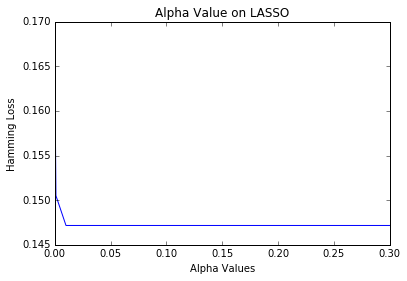

In [173]:
plt.plot(alpha_list, hamming_loss_list)
best_index = np.argmin(hamming_loss_list)
plt.axvline(features_list[best_index], c='r', label= str(best_index))
plt.xlim([0,.3])
plt.ylabel("Hamming Loss")
plt.xlabel("Alpha Values")
plt.title("Alpha Value on LASSO")

## LASSO Predicting Poorly 
It appears that our LASSO continues to do a poor job of predictions even after using LDA to only use 100 of the features. This implies that the LASSO is not able to do enough regularization in order to make reasonable predictions in this smart matrix. This is also an indication that we should likely not use this model. Instead, for the remainder of this section, I will focus on how we might be able to improve our Random Forest model. 

# Extension: Using Different N-Gram for Prediction (Random Forest)
One of the important extensions of using a n-gram model is that we are able to analyze more than individual words. IN a unigram model, we are making predictions purely from individual words and their respective counts. (e.g. "The", "Hello", "War", etc.) From there we make predictions about these movies. 

It's possible, however, that in only using a unigram approach we are losing information. Instead, we might want to analyze our data using more than one grame, likea bigram. An example of a bigram would be two words such as "Not violent",  "Very much" or "no laughs." It's possible that using the second 

In [180]:
hamming_loss_grams = [] 
accuracy_grams = [] 
features_list = [2,4, 6, 8,10,40]
n_grams_list = [1,2,3,4]

for n_grams in n_grams_list:  
    X = get_TFIDF(n_grams = n_grams)
    print "These are the number of grams", n_grams 
    hamming_loss_list = [] 
    accuracy_list = [] 
    for num_features in features_list: 
        print "These are the number of features test", num_features 
        temp_hamming_loss = [] 
        temp_accuracy = [] 
        for train_ind, test_ind in KFold(n_splits = NUM_FOLDS).split(X):
            indices = train_ind
            X_train, X_test = X[train_ind], X[test_ind]
            y_train = y.iloc[train_ind]
            y_test = y.iloc[test_ind]


            text_classifier = OneVsRestClassifier(RandomForestClassifier(max_features = num_features))

            y_hat = text_classifier.fit(X_train, y_train).predict(X_test)

            temp_hamming_loss.append(hamming_loss(y_hat, y_test))
            ### make into numpy array for below function 
            y_test = np.array(y_test)
            ### Our accuracy_score function does not work on matrices, this allows us to 
            ## Take these predictions by row 
            accuracy = [accuracy_score(y_hat[i], y_test[i]) for i in range(0, len(y_test))]
            temp_accuracy.append(np.mean(accuracy))
        hamming_loss_list.append(np.mean(temp_hamming_loss))
        accuracy_list.append(np.mean(temp_accuracy))
    
    hamming_loss_grams.append(hamming_loss_list)
    accuracy_grams.append(accuracy_list)


These are the number of grams 1
These are the number of features test 2
These are the number of features test 4
These are the number of features test 6
These are the number of features test 8
These are the number of features test 10
These are the number of features test 40
These are the number of grams 2
These are the number of features test 2
These are the number of features test 4
These are the number of features test 6
These are the number of features test 8
These are the number of features test 10
These are the number of features test 40
These are the number of grams 3
These are the number of features test 2
These are the number of features test 4
These are the number of features test 6
These are the number of features test 8
These are the number of features test 10
These are the number of features test 40
These are the number of grams 4
These are the number of features test 2
These are the number of features test 4
These are the number of features test 6
These are the number of fe

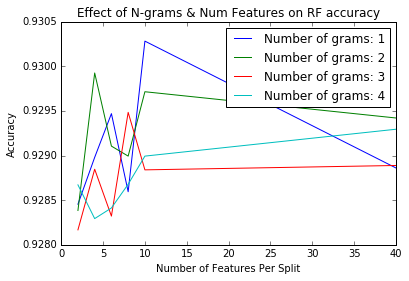

In [202]:
for i, n_gram in enumerate(n_grams_list):
    number_of_grams = "Number of grams: " + str(n_gram)
    plt.plot(features_list,accuracy_grams[i], label = number_of_grams)
plt.legend()
plt.xlabel("Number of Features Per Split")
plt.ylabel("Accuracy")
plt.title("Effect of N-grams & Num Features on RF accuracy")

## Unigram with 10 Features Per Split Does Best 
It appears that our unigram model with 10 features per a split does the best (but only slightly). This might be because in our movie reviews we rarely have a contradicting statement within the summary (i.e. John is NOT in love with Kate") or this movie is "not scary." Instead, the simple word counts seems to do best in our model. The result is that we end up with a model with unigram features that does better than any of our other models. 

## Our Best Predictions
Interestingly, our random forest unigram model does the best of any of our models (We're writing this from the very end, which is why we know this.) It predicts roughly 93% accurately which is roughly 8 points above the baseline. Our other models using neural networks and posters barely reach 86-87%. This indicates that either we are not giving enough data to our neural networks, neural networks do not always beat random forest in performance, or that movie posters provide less information than movie summaries. 